# Regression with Text Input Using BERT and Transformers

- Based on this [medium blog post](https://lajavaness.medium.com/regression-with-text-input-using-bert-and-transformers-71c155034b13);

## Setup

In [1]:
%%time

# Load packages.
import math
import torch

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
from evaluate.loading import load
from torch.utils.data import DataLoader

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix

CPU times: user 2.15 s, sys: 804 ms, total: 2.95 s
Wall time: 9.33 s


In [2]:
# Clear the GPU cache to free up memory.
torch.cuda.empty_cache()

## Dataset

### Download

In [3]:
!pwd

/llm_app


In [4]:
!wget \
    https://gist.githubusercontent.com/ljnmedium/177b80072f04d1ed6f1ca127c053881a/raw/a8c9985abea89abb9f7d75a788206c1324d7fe1c/nhutljn-regression-sentiments.train.jsonlines \
    -O /llm_app/notebooks/tutorials/regression-sentiments.train.jsonlines


--2025-01-09 19:58:43--  https://gist.githubusercontent.com/ljnmedium/177b80072f04d1ed6f1ca127c053881a/raw/a8c9985abea89abb9f7d75a788206c1324d7fe1c/nhutljn-regression-sentiments.train.jsonlines
Resolving usaeast-proxy.us.experian.eeca (usaeast-proxy.us.experian.eeca)... 10.28.246.55, 10.28.246.14, 10.28.246.78
Connecting to usaeast-proxy.us.experian.eeca (usaeast-proxy.us.experian.eeca)|10.28.246.55|:9595... connected.
Proxy request sent, awaiting response... 200 OK
Length: 245947 (240K) [text/plain]
Saving to: ‘/llm_app/notebooks/tutorials/regression-sentiments.train.jsonlines’

          /llm_app/   0%[                    ]       0  --.-KB/s               

/llm_app/notebooks/ 100%[===================>] 240.18K  --.-KB/s    in 0.03s   

2025-01-09 19:58:43 (6.89 MB/s) - ‘/llm_app/notebooks/tutorials/regression-sentiments.train.jsonlines’ saved [245947/245947]



In [5]:
!wget \
    https://gist.githubusercontent.com/ljnmedium/94b5ea0a383976e5b40a2d2a85dadf40/raw/a37f5e81db3aac36d4d0eb8d98f0a22758fc283b/nhutljn-regression-sentiments.validation.jsonlines \
    -O /llm_app/notebooks/tutorials/regression-sentiments.validation.jsonlines

--2025-01-09 19:58:44--  https://gist.githubusercontent.com/ljnmedium/94b5ea0a383976e5b40a2d2a85dadf40/raw/a37f5e81db3aac36d4d0eb8d98f0a22758fc283b/nhutljn-regression-sentiments.validation.jsonlines
Resolving usaeast-proxy.us.experian.eeca (usaeast-proxy.us.experian.eeca)... 10.28.246.78, 10.28.246.55, 10.28.246.14
Connecting to usaeast-proxy.us.experian.eeca (usaeast-proxy.us.experian.eeca)|10.28.246.78|:9595... connected.
Proxy request sent, awaiting response... 200 OK
Length: 53162 (52K) [text/plain]
Saving to: ‘/llm_app/notebooks/tutorials/regression-sentiments.validation.jsonlines’

/llm_app/notebooks/ 100%[===================>]  51.92K  --.-KB/s    in 0.02s   

2025-01-09 19:58:44 (2.95 MB/s) - ‘/llm_app/notebooks/tutorials/regression-sentiments.validation.jsonlines’ saved [53162/53162]



In [6]:
!wget \
    https://gist.githubusercontent.com/ljnmedium/d3c5984c62f4df157e85a5d4d6035272/raw/8ec34e678c9255e146c24ec3eae7e16b6e3d1df0/nhutljn-regression-bert-sentiments.test.jsonlines \
    -O /llm_app/notebooks/tutorials/regression-sentiments.test.jsonlines

--2025-01-09 19:58:44--  https://gist.githubusercontent.com/ljnmedium/d3c5984c62f4df157e85a5d4d6035272/raw/8ec34e678c9255e146c24ec3eae7e16b6e3d1df0/nhutljn-regression-bert-sentiments.test.jsonlines
Resolving usaeast-proxy.us.experian.eeca (usaeast-proxy.us.experian.eeca)... 10.28.246.14, 10.28.246.78, 10.28.246.55
Connecting to usaeast-proxy.us.experian.eeca (usaeast-proxy.us.experian.eeca)|10.28.246.14|:9595... connected.
Proxy request sent, awaiting response... 

200 OK
Length: 54424 (53K) [text/plain]
Saving to: ‘/llm_app/notebooks/tutorials/regression-sentiments.test.jsonlines’

/llm_app/notebooks/ 100%[===================>]  53.15K  --.-KB/s    in 0.01s   

2025-01-09 19:58:44 (3.99 MB/s) - ‘/llm_app/notebooks/tutorials/regression-sentiments.test.jsonlines’ saved [54424/54424]



### Understanding

In [7]:
raw_train_ds = Dataset.from_json(
    "/llm_app/notebooks/tutorials/regression-sentiments.train.jsonlines"
)
raw_val_ds = Dataset.from_json(
    "/llm_app/notebooks/tutorials/regression-sentiments.validation.jsonlines"
)
raw_test_ds = Dataset.from_json(
    "/llm_app/notebooks/tutorials/regression-sentiments.test.jsonlines"
)

# Alex: reduce datasets by half the original size (in order to avoid memory and time constraints).
factor = 1
idx_train = np.random.choice(
    a=np.arange(raw_train_ds.num_rows),
    size=int(raw_train_ds.num_rows * factor),
    replace=False,
)
idx_train.sort()
raw_train_ds = raw_train_ds.select(idx_train)

idx_val = np.random.choice(
    a=np.arange(raw_val_ds.num_rows),
    size=int(raw_val_ds.num_rows * factor),
    replace=False,
)
idx_val.sort()
raw_val_ds = raw_val_ds.select(idx_val)

idx_test = np.random.choice(
    a=np.arange(raw_test_ds.num_rows),
    size=int(raw_test_ds.num_rows * factor),
    replace=False,
)
idx_test.sort()
raw_test_ds = raw_test_ds.select(idx_test)

# This line prints the description of train_ds.
raw_train_ds, raw_val_ds, raw_test_ds

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

(Dataset({
     features: ['id', 'text', 'uuid', 'score'],
     num_rows: 660
 }),
 Dataset({
     features: ['id', 'text', 'uuid', 'score'],
     num_rows: 142
 }),
 Dataset({
     features: ['id', 'text', 'uuid', 'score'],
     num_rows: 142
 }))

In [8]:
raw_train_ds[0]

{'id': 457,
 'text': 'Trop désagréable au téléphone 😡! ! !',
 'uuid': '91c4efaaada14a1b9b050268185b6ae5',
 'score': 1}

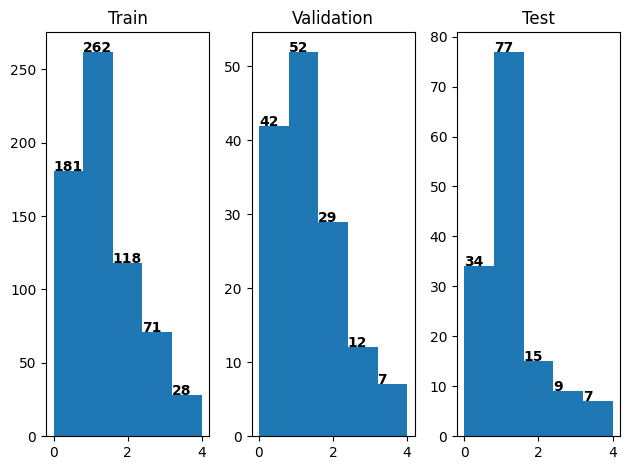

In [9]:
fig, axs = plt.subplots(1, 3, tight_layout=True)
distributions = []

axs[0].set_title("Train")
axs[1].set_title("Validation")
axs[2].set_title("Test")
train_distributions = axs[0].hist(raw_train_ds["score"], bins=5)
val_distributions = axs[1].hist(raw_val_ds["score"], bins=5)
test_distributions = axs[2].hist(raw_test_ds["score"], bins=5)

for distributions, ax in zip(
    [train_distributions, val_distributions, test_distributions], axs
):
    for j in range(5):
        # Display the counts on each column of the histograms
        ax.text(
            distributions[1][j],
            distributions[0][j],
            str(int(distributions[0][j])),
            weight="bold",
        )

## Fine-tuning with a Text Classification Model

In [10]:
%%time

BASE_MODEL = "camembert-base"
LEARNING_RATE = 2e-5
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 20

# Let's name the classes 0, 1, 2, 3, 4 like their indices.
id2label = {k: k for k in range(5)}
label2id = {k: k for k in range(5)}

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(
    BASE_MODEL, id2label=id2label, label2id=label2id
)

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 

CPU times: user 961 ms, sys: 426 ms, total: 1.39 s
Wall time: 1.45 s


### Prepare Datasets

In [11]:
%%time

ds = {"train": raw_train_ds, "validation": raw_val_ds, "test": raw_test_ds}


def preprocess_function(examples):

    label = examples["score"]
    examples = tokenizer(
        examples["text"], truncation=True, padding="max_length", max_length=256
    )
    examples["label"] = label

    return examples


for split in ds:
    ds[split] = ds[split].map(
        preprocess_function, remove_columns=["id", "uuid", "text", "score"]
    )

Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Map:   0%|          | 0/142 [00:00<?, ? examples/s]

Map:   0%|          | 0/142 [00:00<?, ? examples/s]

CPU times: user 537 ms, sys: 14.5 ms, total: 551 ms
Wall time: 565 ms


### Metrics

In [12]:
metric = load("accuracy")


def compute_metrics(eval_pred):

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return metric.compute(predictions=predictions, references=labels)

In [13]:
training_args = TrainingArguments(
    output_dir="/llm_app/models/camembert-fine-tuned-regression",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

In [14]:
%%time

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.383538,0.366197
2,No log,1.282077,0.478873
3,No log,1.056584,0.619718
4,No log,0.992429,0.633803
5,No log,0.916088,0.654930
6,No log,0.926226,0.661972
7,No log,0.948082,0.640845
8,No log,0.957028,0.669014
9,No log,0.979029,0.661972
10,No log,1.018352,0.683099


CPU times: user 9min 16s, sys: 1min 7s, total: 10min 24s
Wall time: 13min 41s


TrainOutput(global_step=840, training_loss=0.46242446899414064, metrics={'train_runtime': 814.8489, 'train_samples_per_second': 16.199, 'train_steps_per_second': 1.031, 'total_flos': 1736579740262400.0, 'train_loss': 0.46242446899414064, 'epoch': 20.0})

### Evaluation

In [15]:
trainer.eval_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'label'],
    num_rows: 142
})

In [16]:
%%time

trainer.evaluate()

CPU times: user 1.93 s, sys: 9.01 ms, total: 1.94 s
Wall time: 1.95 s


{'eval_loss': 1.0183520317077637,
 'eval_accuracy': 0.6830985915492958,
 'eval_runtime': 1.9482,
 'eval_samples_per_second': 72.887,
 'eval_steps_per_second': 4.62,
 'epoch': 20.0}

In [17]:
%%time

trainer.eval_dataset = ds["test"]
trainer.evaluate()

CPU times: user 1.85 s, sys: 0 ns, total: 1.85 s
Wall time: 1.85 s


{'eval_loss': 0.8255395293235779,
 'eval_accuracy': 0.7323943661971831,
 'eval_runtime': 1.8499,
 'eval_samples_per_second': 76.763,
 'eval_steps_per_second': 4.865,
 'epoch': 20.0}

### Prediction

In [18]:
%%time

input_texts = [
    "C'est très bien",
    "Je vais y aller.",
    "J'en ai marre.",
    "Vous ne foutez rien !!!",
    "Je vous remercie infiniment pour cet excellent service !!!",
]

# Encode the text.
encoded = tokenizer(
    input_texts,
    truncation=True,
    padding="max_length",
    max_length=28,  # 256
    return_tensors="pt",
).to("cuda")

# Call the model to predict under the format of logits of 5 classes
logits = model(**encoded).logits

# Get the class
torch.argmax(logits, axis=1)

CPU times: user 23.2 ms, sys: 0 ns, total: 23.2 ms
Wall time: 24.6 ms


tensor([3, 3, 1, 1, 3], device='cuda:0')

## Fine-tuning with a Regression Model

### Setup

In [19]:
# Clear the GPU cache to free up memory.
torch.cuda.empty_cache()

In [20]:
%%time

BASE_MODEL = "camembert-base"
LEARNING_RATE = 2e-5
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 20

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 

CPU times: user 1.06 s, sys: 368 ms, total: 1.43 s
Wall time: 4.63 s


### Prepare Datasets

In [21]:
%%time

ds = {"train": raw_train_ds, "validation": raw_val_ds, "test": raw_test_ds}


def preprocess_function(examples):

    label = examples["score"]
    examples = tokenizer(
        examples["text"], truncation=True, padding="max_length", max_length=256
    )

    # Change this to real number.
    examples["label"] = float(label)

    return examples


for split in ds:
    ds[split] = ds[split].map(
        preprocess_function, remove_columns=["id", "uuid", "text", "score"]
    )

Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Map:   0%|          | 0/142 [00:00<?, ? examples/s]

Map:   0%|          | 0/142 [00:00<?, ? examples/s]

CPU times: user 515 ms, sys: 47 ms, total: 562 ms
Wall time: 564 ms


### Metrics

In [22]:
def compute_metrics_for_regression(eval_pred):

    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    single_squared_errors = ((logits - labels).flatten() ** 2).tolist()

    # Compute accuracy.
    # Based on the fact that the rounded score = true score only if |single_squared_errors| < 0.5
    accuracy = sum([1 for e in single_squared_errors if e < 0.25]) / len(
        single_squared_errors
    )

    return {"mse": mse, "mae": mae, "r2": r2, "accuracy": accuracy}

In [23]:
training_args = TrainingArguments(
    output_dir="/llm_app/models/camembert-fine-tuned-regression",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

### Loss Function

In [24]:
class RegressionTrainer(Trainer):

    def compute_loss(self, model, inputs, return_outputs=False):

        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0][:, 0]
        loss = torch.nn.functional.mse_loss(logits, labels)

        return (loss, outputs) if return_outputs else loss

### Training

In [25]:
%%time

trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Mae,R2,Accuracy
1,No log,1.165882,1.165882,0.876155,0.052826,0.366197
2,No log,0.770925,0.770924,0.654933,0.373694,0.535211
3,No log,0.585798,0.585798,0.591896,0.524092,0.464789
4,No log,0.533173,0.533173,0.557537,0.566845,0.605634
5,No log,0.486687,0.486687,0.514158,0.604611,0.598592
6,No log,0.435139,0.435139,0.483410,0.646489,0.619718
7,No log,0.486891,0.486891,0.515239,0.604445,0.626761
8,No log,0.466866,0.466866,0.493818,0.620714,0.640845
9,No log,0.472513,0.472513,0.500084,0.616126,0.591549
10,No log,0.531174,0.531175,0.536704,0.568469,0.647887


CPU times: user 9min 17s, sys: 1min 3s, total: 10min 21s
Wall time: 13min 26s


TrainOutput(global_step=840, training_loss=0.2309649978365217, metrics={'train_runtime': 806.5566, 'train_samples_per_second': 16.366, 'train_steps_per_second': 1.041, 'total_flos': 1736517373747200.0, 'train_loss': 0.2309649978365217, 'epoch': 20.0})

### Evaluation on Test Set

In [26]:
trainer.eval_dataset = ds["test"]
trainer.evaluate()

{'eval_loss': 0.2767906188964844,
 'eval_mse': 0.2767906188964844,
 'eval_mae': 0.39563262462615967,
 'eval_r2': 0.7292779466879267,
 'eval_accuracy': 0.7112676056338029,
 'eval_runtime': 1.9302,
 'eval_samples_per_second': 73.568,
 'eval_steps_per_second': 4.663,
 'epoch': 20.0}

### Analysis on Mistakes

In [27]:
nb_batches = math.ceil(len(raw_test_ds) / BATCH_SIZE)
y_preds = []

for i in range(nb_batches):
    input_texts = raw_test_ds[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]["text"]
    input_labels = raw_test_ds[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]["score"]
    encoded = tokenizer(
        input_texts,
        truncation=True,
        padding="max_length",
        max_length=256,
        return_tensors="pt",
    ).to("cuda")
    y_preds += model(**encoded).logits.reshape(-1).tolist()

pd.set_option("display.max_rows", 500)
df = pd.DataFrame(
    [raw_test_ds["text"], raw_test_ds["score"], y_preds],
    ["Text", "Score", "Prediction"],
).T
df["Rounded Prediction"] = df["Prediction"].apply(round)

incorrect_cases = df[df["Score"] != df["Rounded Prediction"]]
incorrect_cases

,Text,Score,Prediction,Rounded Prediction
1,Encore en panne depuis hier soir ! Impossible ...,0,0.863155,1
5,Ce centre ne vaut même pas une étoile.. Un num...,0,0.72577,1
6,Je suis venu à la poste cet après-midi pour ré...,0,1.310887,1
8,"USERNAME Bonjour Enedis, j'ai demandé une sous...",1,1.607481,2
9,USERNAME Je rappelle pour la quatrième fois en...,1,1.658358,2
11,Service indigne d'un pays civilisé. Toujours f...,1,0.267461,0
13,"Voilà, c'était ma minute passion pour USERNAME...",2,2.733439,3
14,je suis sois disant pris en compte et je ne pe...,0,1.316026,1
20,Longues lignes. Personnel raciste. Je regarde ...,0,0.763906,1
21,Pole emploi: le plus simple est d'écrire une r...,2,1.185457,1


In [28]:
confusion_matrix(df["Score"].tolist(), df["Rounded Prediction"].tolist())

array([[20, 14,  0,  0,  0],
       [11, 57,  8,  1,  0],
       [ 0,  4,  8,  2,  1],
       [ 0,  0,  0,  9,  0],
       [ 0,  0,  0,  0,  7]])

In [29]:
# Clear the GPU cache to free up memory.
torch.cuda.empty_cache()